# GNN node feature dynamics analysis on number of layers
- note: before using this code, you need to have checkpoints that are saved in the orgnaized folders as defined in train.py
- i.e. need to run train.py (instructions can be found in the file train.py)

In [1]:
PATH = '/Users/jungyoonlee/Desktop/MAT6215-Project/synthetic_experiments/ckpt_real_graph_clean'         # your checkpoint path

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch_geometric.utils import to_edge_index
from sklearn.preprocessing import normalize

from utils import load_full_data, rayleigh_quotient
from models import GRAFFNet

import os

In [10]:
def adj_to_edge_index(adj):
    adj = torch.tensor(normalize(adj + torch.eye(adj.size(0))))
    adj = adj.to_sparse()
    edge_index, _ = to_edge_index(adj) 
    return edge_index

def list_files_in_folder(folder_path):
    files_list = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.pt'):
                files_list.append(os.path.join(root, file))
    return files_list

In [11]:
def get_ckpt_files(dataset:str, model:str, nlayers:str, step_size:float, linear:bool):
    if linear:
        path = f'{PATH}/{dataset}/{model}/linear/ss_{step_size}/nl_{nlayers}'
    else:
        path = f'{PATH}/{dataset}/{model}/act_tanh/ss_{step_size}/nl_{nlayers}'
    files = list_files_in_folder(path)
    target_files = sorted([f for f in files])
    print(target_files)
    return target_files

def get_model_bytype(features_dict, labels_dict, model:str, dataset:str, step_size:float, linear:bool):
    model = GRAFFNet(features_dict[dataset].size(1), 32, labels_dict[dataset].max()+1, 
                      step_size=step_size, model_type=model, linear=linear)
    return model

def get_trained_model_bytype(features_dict, labels_dict, model_type:str, dataset:str, nlayers:int, step_size: float, linear:bool, 
                             ckpt_files:list = None, single_model:bool=True, idx:int=1):
    if ckpt_files is None:
        ckpt_files = get_ckpt_files(dataset, model_type, nlayers, step_size, linear)
    if len(ckpt_files) > 1 and single_model == False:
        models = [get_model_bytype(features_dict, labels_dict, model_type, dataset, step_size, linear) for _ in range(len(ckpt_files))]
        for model, ckpt in zip(models, ckpt_files):
            model.load_state_dict(torch.load(ckpt, map_location='cpu')['model_state_dict'])
    else:
        model = get_model_bytype(features_dict, labels_dict, model_type, dataset, step_size, linear)
        try:
            ckpt=ckpt_files[idx]
        except:
            print(f"{idx} is out of range for ckpt files. Using the first ckpt file.")
            ckpt=ckpt_files[0]
        model.load_state_dict(torch.load(ckpt, map_location='cpu')['model_state_dict'])    
        return model

In [12]:
def layer_sweep(model, edge_index, feat, 
                num_steps=60, hidden_states=32, linear_model=True, step_size_override=None):
    if step_size_override:
        model.step_size = step_size_override

    s0_rq_dict = {}
    s1_rq_dict = {}      

    init_rq = rayleigh_quotient(edge_index, feat.size(0), feat)
    s1_rq_dict[0] = init_rq
    S = torch.zeros(size=(num_steps, feat.size(0), hidden_states))  # states
    S[0,:,:] = model.enc(feat)          
    for num_step in range(num_steps-1):
        if linear_model:
            S[num_step+1,:,:] = S[num_step,:,:] + model.step_size * (model.conv(S[num_step,:,:], edge_index, S[0,:,:]))
        else:
            S[num_step+1,:,:] = S[num_step,:,:] + model.step_size * torch.nn.functional.tanh(model.conv(S[num_step,:,:], 
                                                                                        edge_index, S[0,:,:]))
        s1_rq = rayleigh_quotient(edge_index, feat.size(0), S[num_step+1,:,:])
        s1_rq_dict[num_step+1] = s1_rq.detach().cpu().item()

    print("Done with sweep")
    return s0_rq_dict, s1_rq_dict

### Load Edge/Feature/Labels for each Dataset for easier usage

In [6]:
edge_dict = {}
features_dict = {}
labels_dict = {}

for dataset in ['cora', 'citeseer', 'pubmed',
                'texas','wisconsin','cornell',
                'film', 'chameleon', 'squirrel']: 
    adj, _, feat, label = load_full_data(dataset)
    edge_dict[dataset] = adj.coalesce().indices()
    features_dict[dataset] = feat
    labels_dict[dataset] = label

/Users/jungyoonlee/Desktop/MAT6215-Project/synthetic_experiments/utils.py:484: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:607.)
  return torch.sparse.FloatTensor(indices, values, shape)
/Users/jungyoonlee/Desktop/MAT6215-Project/synthetic_experiments/utils.py:414: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()


### Analysis by Model Types

In [19]:
def plot_per_model(model='graffgcn', num_steps = 60, step_size_override = 0.1, ckpt_idx=0, ax=None,
                   trained:bool=True):
        
    layer_interval=list(range(num_steps))
    
    # if dict_exists:
    #     plt.plot(layer_interval, s1_rq_cora[model].values(), label='Cora')
    #     plt.plot(layer_interval, s1_rq_citeseer[model].values(), label='Citeseer')
    #     plt.plot(layer_interval, s1_rq_squirrel[model].values(), label='Squirrel')
    #     plt.plot(layer_interval, s1_rq_chameleon[model].values(), label='Chameleon')

    # else:
    if trained:
        model_cora = get_trained_model_bytype(features_dict, labels_dict, model, 'cora', 60, step_size_override, True, idx=ckpt_idx)
        model_citeseer = get_trained_model_bytype(features_dict, labels_dict, model, 'citeseer', 60, step_size_override, True, idx=ckpt_idx)
        model_pubmed = get_trained_model_bytype(features_dict, labels_dict, model, 'pubmed', 60, step_size_override, True, idx=ckpt_idx)
        model_texas = get_trained_model_bytype(features_dict, labels_dict, model, 'texas', 60, step_size_override, True, idx=ckpt_idx)
        model_wisconsin = get_trained_model_bytype(features_dict, labels_dict, model, 'wisconsin', 60, step_size_override, True, idx=ckpt_idx)
        model_cornell = get_trained_model_bytype(features_dict, labels_dict, model, 'cornell', 60, step_size_override, True, idx=ckpt_idx)
        model_film = get_trained_model_bytype(features_dict, labels_dict, model, 'film', 60, step_size_override, True, idx=ckpt_idx)
        model_squirrel =  get_trained_model_bytype(features_dict, labels_dict, model, 'squirrel', 60, step_size_override, True, idx=ckpt_idx)
        model_chameleon = get_trained_model_bytype(features_dict, labels_dict, model, 'chameleon', 60, step_size_override, True, idx=ckpt_idx)

    else:
        model_cora = get_model_bytype(features_dict, labels_dict, model, 'cora', step_size_override, True)
        model_citeseer = get_model_bytype(features_dict, labels_dict, model, 'citeseer', step_size_override, True)
        model_pubmed = get_model_bytype(features_dict, labels_dict, model, 'pubmed', step_size_override, True)
        model_texas = get_model_bytype(features_dict, labels_dict, model, 'texas', step_size_override, True)
        model_wisconsin = get_model_bytype(features_dict, labels_dict, model, 'wisconsin', step_size_override, True)
        model_cornell = get_model_bytype(features_dict, labels_dict, model, 'cornell', step_size_override, True)
        model_film = get_model_bytype(features_dict, labels_dict, model, 'film', step_size_override, True)
        model_squirrel = get_model_bytype(features_dict, labels_dict, model, 'squirrel', step_size_override, True)
        model_chameleon = get_model_bytype(features_dict, labels_dict, model, 'chameleon', step_size_override, True)
    
    _, s1_rq_cora = layer_sweep(model_cora, edge_dict['cora'], features_dict['cora'], 
                                num_steps=num_steps, linear_model=model_cora.linear, step_size_override=step_size_override)
    _, s1_rq_citeseer = layer_sweep(model_citeseer, edge_dict['citeseer'], features_dict['citeseer'], 
                                num_steps=num_steps, linear_model=model_citeseer.linear, step_size_override=step_size_override)
    _, s1_rq_pubmed = layer_sweep(model_pubmed, edge_dict['pubmed'], features_dict['pubmed'],
                                num_steps=num_steps, linear_model=model_pubmed.linear, step_size_override=step_size_override)
    _, s1_rq_texas = layer_sweep(model_texas, edge_dict['texas'], features_dict['texas'],
                                num_steps=num_steps, linear_model=model_texas.linear, step_size_override=step_size_override)
    _, s1_rq_wisconsin = layer_sweep(model_wisconsin, edge_dict['wisconsin'], features_dict['wisconsin'],
                                num_steps=num_steps, linear_model=model_wisconsin.linear, step_size_override=step_size_override)      
    _, s1_rq_cornell = layer_sweep(model_cornell, edge_dict['cornell'], features_dict['cornell'],
                                num_steps=num_steps, linear_model=model_cornell.linear, step_size_override=step_size_override)
    _, s1_rq_film = layer_sweep(model_film, edge_dict['film'], features_dict['film'],
                                num_steps=num_steps, linear_model=model_film.linear, step_size_override=step_size_override)  
    _, s1_rq_chameleon = layer_sweep(model_chameleon , edge_dict['chameleon'], features_dict['chameleon'], 
                                num_steps=num_steps, linear_model=model_chameleon.linear, step_size_override=step_size_override)
    _, s1_rq_squirrel = layer_sweep(model_squirrel, edge_dict['squirrel'], features_dict['squirrel'], 
                                num_steps=num_steps, linear_model=model_squirrel.linear, step_size_override=step_size_override)
    
    if ax is not None:
        ax.plot(layer_interval, s1_rq_cora.values(), label='Cora')
        ax.plot(layer_interval, s1_rq_citeseer.values(), label='Citeseer')
        ax.plot(layer_interval, s1_rq_pubmed.values(), label='Pubmed')
        ax.plot(layer_interval, s1_rq_squirrel.values(), label='Squirrel')
        ax.plot(layer_interval, s1_rq_chameleon.values(), label='Chameleon')
        ax.plot(layer_interval, s1_rq_texas.values(), label='Texas')
        ax.plot(layer_interval, s1_rq_wisconsin.values(), label='Wisconsin')
        ax.plot(layer_interval, s1_rq_cornell.values(), label='Cornell')
        ax.plot(layer_interval, s1_rq_film.values(), label='Film')

    else:
        plt.plot(layer_interval, s1_rq_cora.values(), label='Cora')
        plt.plot(layer_interval, s1_rq_citeseer.values(), label='Citeseer')
        plt.plot(layer_interval, s1_rq_pubmed.values(), label='Pubmed')
        plt.plot(layer_interval, s1_rq_squirrel.values(), label='Squirrel')
        plt.plot(layer_interval, s1_rq_chameleon.values(), label='Chameleon')
        plt.plot(layer_interval, s1_rq_texas.values(), label='Texas')
        plt.plot(layer_interval, s1_rq_wisconsin.values(), label='Wisconsin')
        plt.plot(layer_interval, s1_rq_cornell.values(), label='Cornell')
        plt.plot(layer_interval, s1_rq_film.values(), label='Film')

        # Adding labels and legend
        plt.xlabel('Num Layers')
        plt.ylabel('RQ')
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), 
                fancybox=True, shadow=True, ncol=3, fontsize=8)

### Plotting with different step sizes

In [8]:
num_steps=60
step_sizes = [0.01, 0.1, 0.5, 0.95]

Done with sweep
Done with sweep
Done with sweep
Done with sweep
Done with sweep
Done with sweep
Done with sweep
Done with sweep
Done with sweep


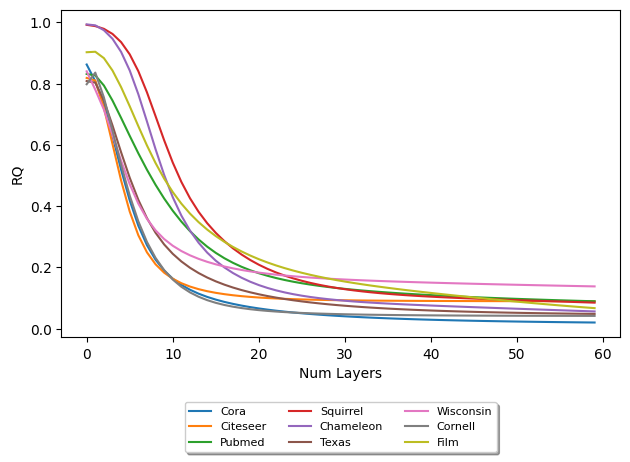

In [20]:
# Call plot_per_model for each subplot
plot_per_model(model='graffgcn', num_steps=num_steps, step_size_override=0.5, trained=False)
plt.tight_layout()
plt.show()

['/Users/jungyoonlee/Desktop/MAT6215-Project/synthetic_experiments/ckpt_real_graph_clean/cora/graffgcn/linear/ss_0.5/nl_60/norm_none/run_idx_0_epoch_99.pt', '/Users/jungyoonlee/Desktop/MAT6215-Project/synthetic_experiments/ckpt_real_graph_clean/cora/graffgcn/linear/ss_0.5/nl_60/norm_none/run_idx_1_epoch_99.pt', '/Users/jungyoonlee/Desktop/MAT6215-Project/synthetic_experiments/ckpt_real_graph_clean/cora/graffgcn/linear/ss_0.5/nl_60/norm_none/run_idx_2_epoch_99.pt']
['/Users/jungyoonlee/Desktop/MAT6215-Project/synthetic_experiments/ckpt_real_graph_clean/citeseer/graffgcn/linear/ss_0.5/nl_60/norm_none/run_idx_0_epoch_99.pt', '/Users/jungyoonlee/Desktop/MAT6215-Project/synthetic_experiments/ckpt_real_graph_clean/citeseer/graffgcn/linear/ss_0.5/nl_60/norm_none/run_idx_1_epoch_99.pt', '/Users/jungyoonlee/Desktop/MAT6215-Project/synthetic_experiments/ckpt_real_graph_clean/citeseer/graffgcn/linear/ss_0.5/nl_60/norm_none/run_idx_2_epoch_99.pt']
['/Users/jungyoonlee/Desktop/MAT6215-Project/synth

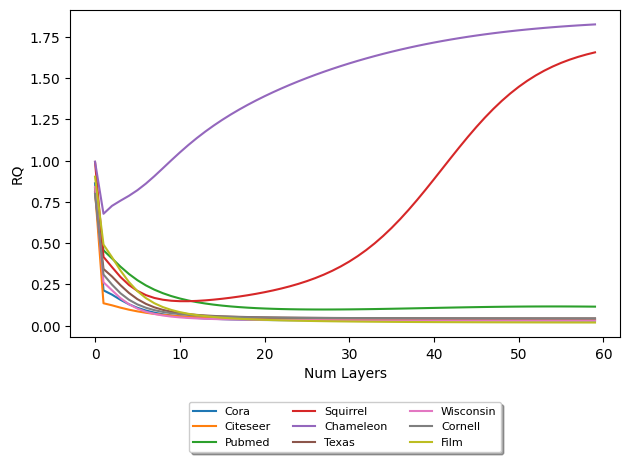

In [22]:
# Call plot_per_model for each subplot
plot_per_model(model='graffgcn', num_steps=num_steps, step_size_override=0.5, trained=True, ckpt_idx=1)
plt.tight_layout()
plt.show()